In [10]:
import os
import sys
import re
import itertools
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import logging, gensim
from gensim import corpora, models, similarities,matutils
from gensim.parsing.preprocessing import STOPWORDS

import nltk
# nltk.download()
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

from scipy.spatial import distance

import sklearn.datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

In [14]:
def process_message(message):
    """
    Preprocess a single 20newsgroups message, returning the result as
    a unicode string.
    
    """
    extracted = 1
    message = gensim.utils.to_unicode(message, 'latin1').strip()
    logging.info("extracting 20newsgroups file #%i: %s" % (extracted,message[:10]))
    return message

In [2]:
# # Load Data
# corpus = corpora.MmCorpus('20newsgroup.mm')
# dictionary = corpora.Dictionary.load('20newsgroup.dict')

In [7]:
train = sklearn.datasets.fetch_20newsgroups(subset='train',remove=('headers','footers','quotes'))
# train = sklearn.datasets.fetch_20newsgroups(subset='train')
test = sklearn.datasets.fetch_20newsgroups(subset='test')

In [16]:
#train.target_names
#train.filenames
#train.target[:10]
documents = train.data
process_message(documents[1])

INFO:root:extracting 20newsgroups file #1: A fair num


"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [144]:
# nltk.download()
# test = word_tokenize(documents[1])
tokenizer = RegexpTokenizer(r'\w+')
s = nltk.stem.SnowballStemmer('english')
stop = stopwords.words('english')
texts = []

# [texts.append(set([s.stem(word) for sent in sent_tokenize(doc) for word in tokenizer.tokenize(sent) if word.lower() not in stop])) for doc in documents]

# stopwords are in lower case ... 
# for doc in documents:
#     for sent in sent_tokenize(doc):
#         texts.append([s.stem(word) for word in tokenizer.tokenize(sent) if word.lower() not in stop])

for doc in documents:
    texts.append([s.stem(word) for word in tokenizer.tokenize(doc) if word.lower() not in stop])

In [145]:
# dictionary = corpora.Dictionary(line.lower().split() for line in open('mycorpus.txt'))
# Maps a word to a ID
dictionary = corpora.Dictionary(texts)
dictionary.save('20newsgroup.dict') # store the dictionary, for future reference
# print(dictionary)
# print(dictionary.token2id)

In [146]:
newsgrp20 = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('20newsgroup.mm', newsgrp20) # store to disk, for later use
# newsgrp20 = corpora.MmCorpus('20newsgroup.mm')
# Word ID , Frequency for each document
# print(newsgrp20)

In [ ]:
# tfidf = models.TfidfModel(newsgrp20) # Initialize Tfidf
# corpus_tfidf = tfidf[newsgrp20] # Transform Test Corpus

# lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
# corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: corpus->tfidf->fold-in-lsi

lda_model = models.ldamodel.LdaModel(newsgrp20, id2word=dictionary, num_topics=100,passes=10)
# model = hdpmodel.HdpModel(bow_corpus, id2word=dictionary)

In [148]:
# topics = lda_model[newsgrp20]
lda_model.show_topics()

[(1,
  '0.010*write + 0.009*edu + 0.008*com + 0.007*one + 0.007*would + 0.007*peopl + 0.006*articl + 0.006*like + 0.006*get + 0.005*chip'),
 (67,
  '0.017*edu + 0.009*like + 0.009*get + 0.008*write + 0.008*myer + 0.007*appl + 0.007*duo + 0.006*articl + 0.006*would + 0.006*com'),
 (30,
  '0.572*ax + 0.042*max + 0.024*q + 0.021*3 + 0.014*g9v + 0.012*p + 0.011*7 + 0.009*r + 0.008*g + 0.008*n'),
 (39,
  '0.022*1 + 0.018*2 + 0.015*use + 0.013*3 + 0.011*printer + 0.008*print + 0.007*4 + 0.007*5 + 0.007*format + 0.006*imag'),
 (15,
  '0.013*armenian + 0.009*one + 0.008*peopl + 0.006*said + 0.005*turkish + 0.005*know + 0.005*say + 0.005*turk + 0.005*go + 0.005*turkey'),
 (82,
  '0.010*ax + 0.007*3 + 0.007*q + 0.006*reinstal + 0.006*za + 0.005*x + 0.005*8051 + 0.004*g + 0.004*3x + 0.004*1'),
 (41,
  '0.013*com + 0.011*ivf + 0.010*idl + 0.009*sgi + 0.009*trunk + 0.007*silicon + 0.007*rash + 0.007*386bsd + 0.006*mislead + 0.006*svr4'),
 (4,
  '0.023*ax + 0.019*einstein + 0.008*albert + 0.007*para

In [149]:
doc_num = 0
topic_index = [int(i[0]) for i in topics[doc_num]]
print(topic_index)
print([(i[1]) for i in topics[doc_num]])
print([dictionary.id2token[x] for x in topic_index])
print(documents[doc_num])
    
    

[15, 18, 29, 56, 61, 63, 95]
[0.071825355564549401, 0.041109278803422564, 0.084390555880771073, 0.092887532429586347, 0.20686000864636928, 0.028660225666514026, 0.45671987319746593]
['mail', 'spec', 'small', 'washington', 'next', 'number', 'hour']
 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

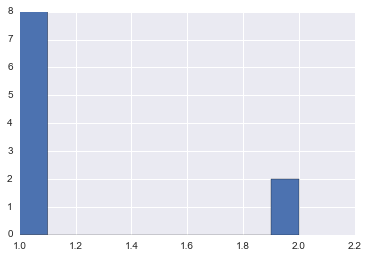

In [164]:
num_topics = [len(lda_model[doc]) for doc in corpus_tfidf]
plt.hist(num_topics)

In [86]:
# x = np.array([[1,2],[2,4]])
# print("x ",x.shape) - 2,2
# y = np.array([[1,2],[2,4]])
# print("x ",y.shape) 

x  (2, 2)


In [59]:
# s = nltk.stem.SnowballStemmer('english')
# class StemmedTfidfVectorizer(TfidfVectorizer):
#     def build_analyzer(self):
#         #StemmedCountVectorizer will return CountVectorizer build_analyzer code
#         analyzer = super(TfidfVectorizer,self).build_analyzer()
#         return lambda doc: (s.stem(w) for w in analyzer(doc))

# # default min_df = 1, max_df = 1.0
# # In other words, tf-idf weight in document that is
# # highest when the terms occurs many times within a small number of documents (thus lending high discriminating power to those documents);
# # lower when the term occurs fewer times in a document, or occurs in many documents (thus offering a less pronounced relevance signal);
# # lowest when the term occurs in virtually all documents.
# vectorizer = StemmedTfidfVectorizer(min_df=1,stop_words='english',decode_error='ignore')

# vectorized = vectorizer.fit_transform(documents)
# features = np.array(vectorizer.get_feature_names())
# # type(features)
# texts = [list(features[list((vectorized>0)[i].nonzero()[1])]) for i,doc in enumerate(documents)]